## Benchmarking genetic perturbation prediction in human PSC's

This project aims to assess the ability of modern datasets and software tools to predict the effect of genetic perturbations on the transcriptome. Check out [the proposal](https://docs.google.com/document/d/1vvZi5c0nU3VTvKiWpEka8AtDORxJ3Ymv0ZzoFQwoDoI/edit) for more information.

There are several opportunities for interesting work in this area. This demo focuses on *causal structure inference* and *causal effect estimation* by pairing CellOracle with various different base networks. 

In [2]:
VERSION="v3"
import warnings
with warnings.catch_warnings():
    import regex as re
    import os
    import sys
    import importlib
    import matplotlib.colors as colors
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import scanpy as sc
    import seaborn as sns
    import celloracle as co
    from scipy.stats import spearmanr as spearmanr
    # visualization settings
    %config InlineBackend.figure_format = 'retina'
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [6, 4.5]
    plt.rcParams["savefig.dpi"] = 300

    try:
        os.makedirs("../results/" + VERSION)
    except:
        pass

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/trajectory/markov_simulation.py:17: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_walk" failed type inference due to: Undecided type $22load_method.7 := <undecided>
During: resolving caller type: $22load_method.7
During: typing of call at /home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/trajectory/markov_simulation.py (40)


File "../../../../../../../../.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/trajectory/markov_simulation.py", line 40:
def _walk(start_cell_id_array, transition_prob, n_steps):
    <source elided>

    li.append(list(ids_now))
    ^

  @jit(i8[:,:](i8[:], f8[:,:], i8))
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/trajectory/markov_simulation.

### Networks

This sets up access to a collection of pre-built regulatory networks and coexpression networks. 

In [3]:
sys.path.append(os.path.expanduser('/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/networks/load_networks/')) 
import load_networks
importlib.reload(load_networks) #under development; get latest easily
os.environ["GRN_PATH"] = "../../networks/networks/"

### Basic infrastructure

The software for this project will provide quick access to a variety of modeling choices, especially different base networks, different network structure pruning methods, possibly different learning algorithms, and definitely different handling of velocity and timestamps. We will try to separate this into one-off components specific to each dataset or comparison and reusable components. Here is a rough draft of one reusable component, for training models with various base networks.

In [4]:
def trainCausalModelAndPredict(expression, 
                               baseNetwork, 
                               memoizationName,
                               perturbations,
                               clusterColumnName,
                               pruningParameters = {"p":0.001, "threshold_number":2000}):
    """Train a causal model and predict outcomes of unseen perturbations."""
    print("Working on " + memoizationName)
    oracle = co.Oracle()
    oracle.import_anndata_as_raw_count(adata=ko_lab_esc_data,
                                   cluster_column_name=clusterColumnName,
                                   embedding_name="X_pca")
    oracle.import_TF_data(TF_info_matrix=baseNetwork)
    oracle.perform_PCA()
    n_comps = 50
    k = 1
    oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                          b_maxl=k*4, n_jobs=4)
    # Ridge regression pruning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        links = oracle.get_links(cluster_name_for_GRN_unit=clusterColumnName, 
                                 alpha=10, 
                                 model_method = "bayesian_ridge",
                                 verbose_level=10,    
                                 test_mode=False, 
                                 n_jobs=14)
        links.filter_links(p=pruningParameters["p"], 
                           weight="coef_abs", 
                           threshold_number=pruningParameters["threshold_number"])
    
    links.links_dict = links.filtered_links.copy()
    oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
    oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)
    oracle.to_hdf5(file_path=memoizationName)

    output = {}
    for goi, level in perturbations:
        print("Predicting " + goi)
        try:
            oracle.simulate_shift(perturb_condition={goi: level}, n_propagation=3, ignore_warning = True)
            output[goi] = oracle.adata["Control",:].layers['simulated_count'].squeeze()
        except ValueError as e:
            output[goi] = np.nan
            print("Prediction failed for " + goi + " with error " + str(e))
    return output

### Base network options

The project will also develop a reusable collection of datasets on *perturbation experiments* and *network structures* stored in a standardized format. This is not very far along at time of writing, but here are some of the network structures we will use for this example. 

- A completely dense network with all connections allowed
- A completely empty network with no connections allowed (EDIT: CellOracle refuses to make predictions based on an empty network. I have substituted a random network. Edges are present with 10% probability, all independent.)
- CellOracle default (motif analysis of promoters)
- Motif analysis of FANTOM5 CAGE-seq data
- Coexpression analysis from the CellNet compendia


In [95]:
humanTFs = pd.read_csv("../../accessory_data/humanTFs.csv")
targetGenes = co.data.load_human_promoter_base_GRN()["gene_short_name"]

def networkEdgesToMatrix(networkEdges, regulatorColumn=0, targetColumn=1):
    """Reformat a network from a two-column dataframe to the way that celloracle needs its input."""
    X = pd.crosstab(networkEdges.iloc[:,targetColumn], networkEdges.iloc[:,regulatorColumn])
    X = 1.0*(X > 0)
    X = X.rename_axis('gene_short_name').reset_index()
    X = X.rename_axis('peak_id').reset_index()
    return X

def makeRandomNetwork(density = 0, seed = 0):
    """Format an random network the way that celloracle needs its input."""
    np.random.seed(seed)
    return pd.DataFrame(
            np.random.binomial(
                n = 1, 
                p=density,
                size=(
                    len(targetGenes), 
                    len(humanTFs['HGNC symbol'])
                )
            ),
            columns = humanTFs['HGNC symbol'], 
            index = targetGenes
        ).rename_axis('gene_short_name').reset_index().rename_axis('peak_id').reset_index()

networks = {
    'dense': makeRandomNetwork(density = 1),
    'random0.1': makeRandomNetwork(density = 0.1),
    'cellOracle': co.data.load_human_promoter_base_GRN(),
    'fantom5': networkEdgesToMatrix(load_networks.load_grn_all_subnetworks("magnum_compendium_394")),
    'cellnet': networkEdgesToMatrix(load_networks.load_grn_all_subnetworks("cellnet_human_Hg1332"))
}

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2
Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [96]:
# Inspect for correctness.
# They should all be zeroes and ones.
print({bn:np.unique(networks[bn].iloc[:,2:]) for bn in networks})

{'dense': array([1]), 'random0.1': array([0, 1]), 'cellOracle': array([0., 1.]), 'fantom5': array([False,  True]), 'cellnet': array([False,  True])}


In [98]:
# Inspect sizes. 
network_sizes = {bn:networks[bn].iloc[:,2:].sum().sum() for bn in networks}
network_sizes

{'dense': 102313295,
 'random0.1': 10227517,
 'cellOracle': 5134330.0,
 'fantom5': 3246008,
 'cellnet': 201422}

### PSC overexpression example

This demo uses a dataset with hundreds of individual overexpression experiments applied to pluripotent stem cells ([Nakatake et al 2020](https://www.sciencedirect.com/science/article/pii/S2211124720306082)). This choice of dataset is meant to be an easy starting point: the time-scale (48 hours) is fairly short-term, the cell state (pluripotency) is well studied,  and the perturbations are numerous (714 genes including 481 TF's). The dataset is also small (~1k samples) so testing/debugging is fast. 

Here we tidy the PSC overexpression dataset and carry out a simple exploration in scanpy. (It's not single cell data but scanpy is clearly a useful place to start.) The data contain both microarray and RNA-seq measurements, but these have already been effectively integrated by the authors using a strategy akin to quantile normalization. There are missing values marked -9999, which include genes missing from microarrays and outlying measurements censored by the creators. For now, missing values are being filled in with control gene expression. 

There are three types of controls, which are bundled together in this code. 

In [99]:
controls = ("Emerald", "Control", "CAG-rtTA35-IH")
ko_lab_esc_data = pd.read_csv("../../raw_perturbations/ko_esc/CREST_06162021.txt", 
                              delimiter="\t", index_col=0, header=0, comment = '!')
gene_metadata   = ko_lab_esc_data.iloc[:,-4:]
ko_lab_esc_data = ko_lab_esc_data.iloc[:, 0:-4].T
sample_metadata = pd.DataFrame(columns = ["perturbation"], 
                               index = ko_lab_esc_data.index,
                               data = [re.sub("\..", "", g) for g in ko_lab_esc_data.index])
for c in controls:
    assert c in sample_metadata['perturbation'].unique() 

In [100]:
def missingDataPerGene(ko_lab_esc_data):
    gene_metadata["fraction_missing"] = pd.DataFrame.mean(ko_lab_esc_data==-9999)
    missingness_rates = gene_metadata["fraction_missing"].value_counts()
    missingness_rates = pd.DataFrame(index = range(len(missingness_rates.index)), 
                                 data = {"Fraction of samples missing":np.array(missingness_rates.index), 
                                         "Number of genes": np.array(missingness_rates)})
    print("Missing data per gene:")
    print(missingness_rates)
    
missingDataPerGene(ko_lab_esc_data)
for sample in ko_lab_esc_data.index:
    missing = ko_lab_esc_data.loc[sample,:]==-9999
    ko_lab_esc_data.loc[sample,missing] = ko_lab_esc_data.loc["Control",missing]
missingDataPerGene(ko_lab_esc_data)

ko_lab_esc_data = sc.AnnData(ko_lab_esc_data, 
                             var = gene_metadata,
                             obs = sample_metadata)
ko_lab_esc_data

Missing data per gene:
   Fraction of samples missing  Number of genes
0                     0.000000            20032
1                     0.151186             4804
2                     0.000988              214
3                     0.152174               33
4                     0.001976                7
Missing data per gene:
   Fraction of samples missing  Number of genes
0                          0.0            25090


AnnData object with n_obs × n_vars = 1012 × 25090
    obs: 'perturbation'
    var: 'Symbol', 'Gene title', 'GENBANK', 'Entrez', 'fraction_missing'

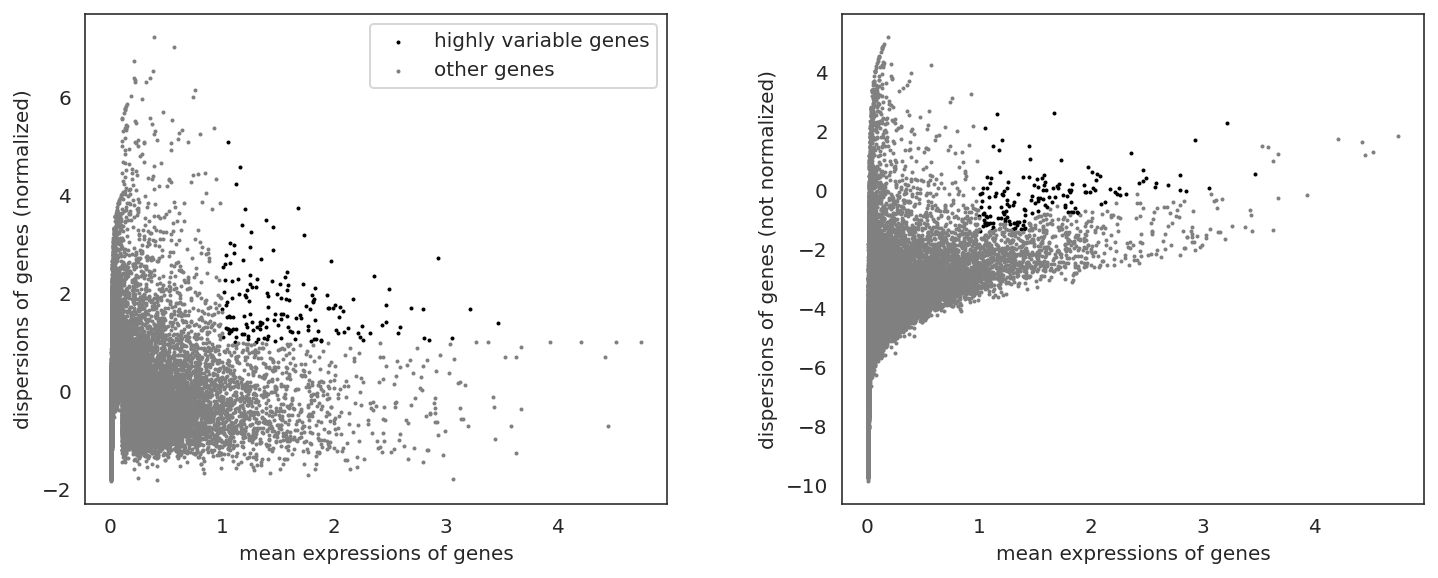

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'perturbation' as categorical
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Symbol' as categorical
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning

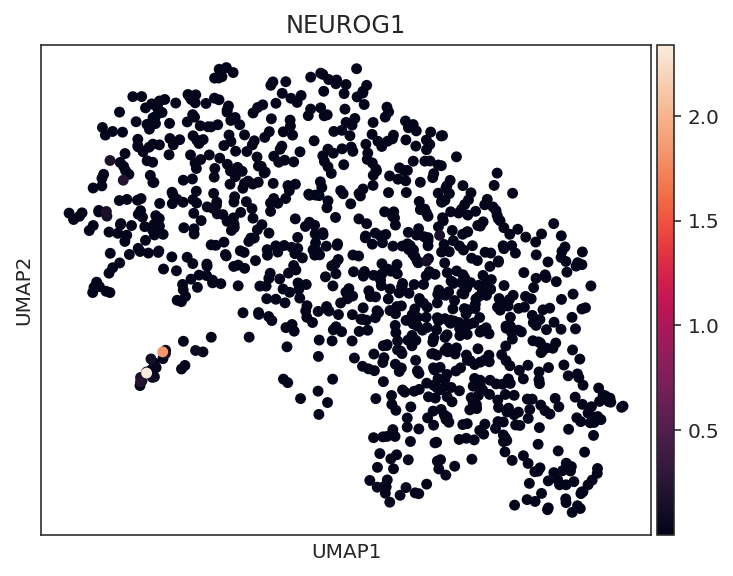

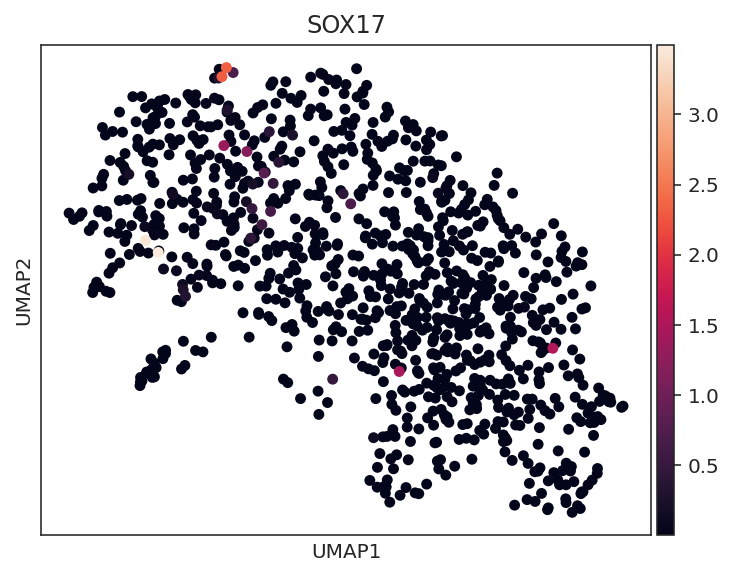

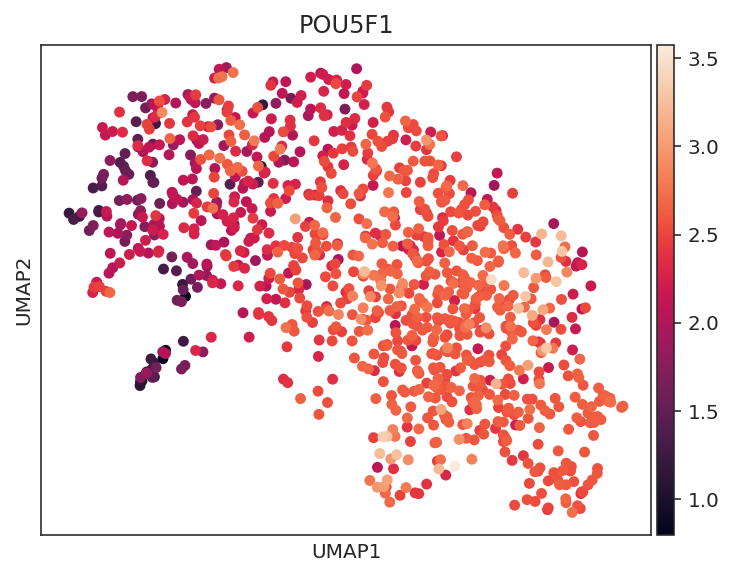

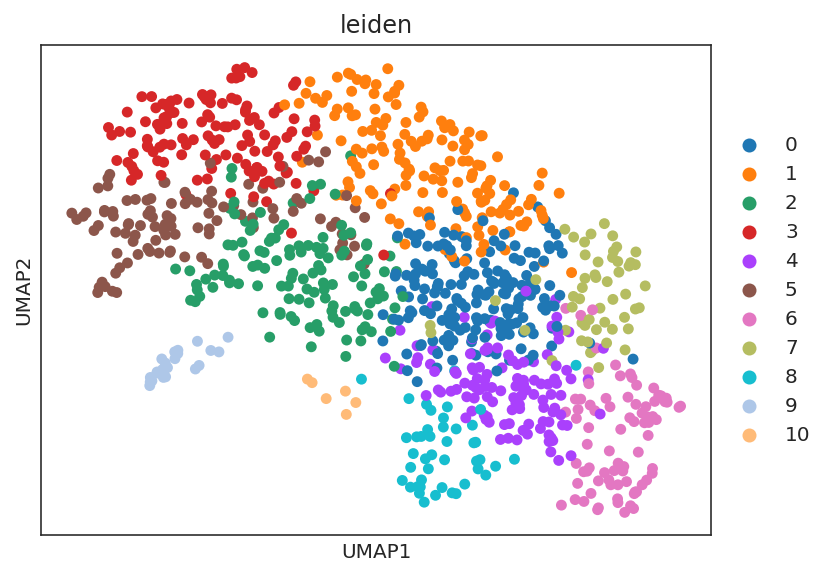

In [101]:
sc.pp.normalize_total(ko_lab_esc_data, target_sum=1e4)
sc.pp.log1p(ko_lab_esc_data)
sc.pp.highly_variable_genes(ko_lab_esc_data, min_mean=1, max_mean=4, min_disp=1, n_bins=50)
sc.pl.highly_variable_genes(ko_lab_esc_data)
with warnings.catch_warnings():
    sc.tl.pca(ko_lab_esc_data, n_comps=100)
sc.pp.neighbors(ko_lab_esc_data)
sc.tl.umap(ko_lab_esc_data)
sc.tl.leiden(ko_lab_esc_data)
sc.pl.umap(ko_lab_esc_data, color = "NEUROG1")
sc.pl.umap(ko_lab_esc_data, color = "SOX17")
sc.pl.umap(ko_lab_esc_data, color = "POU5F1")
sc.pl.umap(ko_lab_esc_data, color = "leiden")
ko_lab_esc_data.obs["fake_cluster"]="all_one_cluster"

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [102]:
perturbed_genes = set(list(ko_lab_esc_data.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(ko_lab_esc_data.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(ko_lab_esc_data.var.index)
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
genes_keep = ko_lab_esc_data.var.index[ko_lab_esc_data.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
ko_lab_esc_data = ko_lab_esc_data[:,list(genes_keep)]

These genes were perturbed but not measured:
{'T', 'DUX4'}


### Training and test split

A few factors complicate the training-test split. 

- Perturbed genes may be absent from most base GRN's due to lack of motif information or ChIP data. These are excluded from the test data to avoid obvious failure cases.
- Perturbed genes may not be measured. These are excluded from test data because we don't know to what extent they were overexpressed.

In both cases, we still use those perturbed profiles as training data, hoping they will provide useful info about attainable cell states and downstream causal effects. There are so many factors ineligible for use as test data that we use all the eligible ones for test and the only ineligible ones for training. 

In [103]:
test_set_regulators = set.intersection(*[set(networks[key]['gene_short_name']) 
                                      for key in networks if not key == 'empty'])
test_set_regulators = test_set_regulators.difference(perturbed_but_not_measured_genes)
testSetPerturbations     = set(ko_lab_esc_data.obs['perturbation']).intersection(test_set_regulators)
trainingSetPerturbations = set(ko_lab_esc_data.obs['perturbation']).difference(test_set_regulators)
ko_lab_esc_data_heldout  = ko_lab_esc_data[ko_lab_esc_data.obs["perturbation"].isin(testSetPerturbations),    :]
ko_lab_esc_data_train    = ko_lab_esc_data[ko_lab_esc_data.obs["perturbation"].isin(trainingSetPerturbations),:]
ko_lab_esc_data_train.obs['perturbation'].unique()
perturbationsToPredict = [(gene, ko_lab_esc_data_heldout[sample, gene].X[0,0]) for sample,gene in enumerate(ko_lab_esc_data_heldout.obs['perturbation'])] 
print("Example perturbations formatted as \n (gene, expression after perturbation)")
print(perturbationsToPredict[0:5])
print("Test set size:")
print(len(testSetPerturbations))
print("Training set size:")
print(len(trainingSetPerturbations))
# ko_lab_esc_data_train


Example perturbations formatted as 
 (gene, expression after perturbation)
[('ANKRD22', 0.43029666), ('ANKRD22', 0.46850818), ('ARID3A', 2.8244312), ('ARID3A', 2.6300352), ('ARNT2', 3.8641534)]
Test set size:
288
Training set size:
225


### OK, let's do this. 

In [104]:
n_networks = len(networks.keys())
experiments = pd.DataFrame({"network":[n for n in networks.keys()]*2, 
                            "p":[0.001, 1]*n_networks,
                            "threshold_number":[2000, max(network_sizes.values())]*n_networks,
                            "pruning":["harsh", "none"]*n_networks})
experiments["index"] = experiments.index
experiments.to_csv("../results/" + VERSION + "/networkExperiments.csv")

In [105]:
predictions = {
    i: trainCausalModelAndPredict(expression=ko_lab_esc_data_train,
                                  baseNetwork=networks[experiments.loc[i,'network']],
                                  memoizationName="../results/" + VERSION + "/" + str(i) + ".celloracle.oracle", 
                                  perturbations=perturbationsToPredict,
                                  clusterColumnName = "fake_cluster",
                                  pruningParameters = {"p":experiments.loc[i,'p'], 
                                                       "threshold_number":experiments.loc[i,'threshold_number']}) 
    for i in experiments.index
}


653 genes were found in the adata. Note that Celloracle is intended to use 1000 to 3000 genes, so the behavior with this number of genes may differ from what is expected.


  0%|          | 0/11 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 1...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 10...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 2...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 3...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 4...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 5...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 7...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 8...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 9...


  0%|          | 0/629 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in 0


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 94 genes
calculating GRN in 1


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 127 genes
calculating GRN in 10


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 282 genes
calculating GRN in 2


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 155 genes
calculating GRN in 3


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 213 genes
calculating GRN in 4


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 73 genes
calculating GRN in 5


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 228 genes
calculating GRN in 6


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 73 genes
calculating GRN in 7


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 138 genes
calculating GRN in 8


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 166 genes
calculating GRN in 9


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 318 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Prediction failed for BATF with error Gene BATF does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting BATF
Prediction failed for BATF with error Gene BATF does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting BATF3
Predicting BATF3
Predicting BCL6


Predicting LMO2
Predicting MAB21L2
Prediction failed for MAB21L2 with error Gene MAB21L2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting MAB21L2
Prediction failed for MAB21L2 with error Gene MAB21L2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting MEF2C
Predicting MEF2C
Predicting MEIS1
Predicting MEIS1
Predicting MEIS2
Predicting MEIS2
Predicting MKRN1
Predicting MKRN1
Predicting MNX1
Predicting MNX1
Predicting MSC
Predicting MSC
Predicting MSX2
Predicting MSX2
Predicting MXI1
Predicting MXI1
Predicting MYB
Predicting MYB
Predicting MYBL2
Predicting MYBL2
Predicting MYC
Predicting MYC
Predicting MYF5
Predicting MYF5
Predicting MYF6
Predicting MYF6
Predicting MYOD1
Predicting MYOD1
Predicting NANOG
Predicting NANOG
Predicting NEUROD1
Predicting NEUROD1
Predicting NEUROD2
Predicting NEUROD2
Predicting NEUROD6
Predicting NEUROD6
Predic

Predicting ZBTB3
Predicting ZBTB3
Predicting ZIC1
Predicting ZIC1
Predicting ZIC3
Predicting ZIC3
Predicting ZMAT4
Predicting ZMAT4
Predicting ZMYND12
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ZMYND12
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ZNF274
Predicting ZNF274
Predicting ZNF281
Predicting ZNF281
Predicting ARID3B
Predicting ARID3B
Predicting BMP2
Predicting BMP2
Predicting BMP7
Predicting BMP7
Predicting CBFB
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif inf

  0%|          | 0/11 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 1...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 10...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 3...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 4...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 5...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/629 [00:00<?, ?it/s]

inferring GRN for 7...


  0%|          | 0/629 [00:00<?, ?it/s]

inferring GRN for 8...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 9...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in 0


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 1


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 10


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 2


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 3


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 4


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 5


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 6


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 7


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 8


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 9


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Predicting BATF
Predicting BATF3
Predicting BATF3
Predicting BCL6
Predicting BCL6
Predicting BMP4
Predicting BMP4
Predicting BRF2
Predicting BRF2
Predicting CBX2
Predicting CBX2
Predicting CCNE1
Prediction failed for CCNE1 with error Gene CCNE1 is not included in the base GRN; It is not TF or TF motif information is not availa

Predicting MEF2C
Predicting MEIS1
Predicting MEIS1
Predicting MEIS2
Predicting MEIS2
Predicting MKRN1
Predicting MKRN1
Predicting MNX1
Predicting MNX1
Predicting MSC
Predicting MSC
Predicting MSX2
Predicting MSX2
Predicting MXI1
Predicting MXI1
Predicting MYB
Predicting MYB
Predicting MYBL2
Predicting MYBL2
Predicting MYC
Predicting MYC
Predicting MYF5
Predicting MYF5
Predicting MYF6
Predicting MYF6
Predicting MYOD1
Predicting MYOD1
Predicting NANOG
Predicting NANOG
Predicting NEUROD1
Predicting NEUROD1
Predicting NEUROD2
Predicting NEUROD2
Predicting NEUROD6
Predicting NEUROD6
Predicting NEUROG1
Predicting NEUROG1
Predicting NFATC1
Predicting NFATC1
Predicting NFE2L1
Predicting NFIB
Predicting NFIB
Predicting NFIC
Predicting NFIC
Predicting NFIL3
Predicting NFIL3
Predicting NKX2-1
Predicting NKX2-1
Predicting NKX2-2
Predicting NKX2-2
Predicting NKX2-5
Predicting NKX2-5
Predicting NKX6-2
Predicting NKX6-2
Predicting NPAS2
Predicting NPAS2
Predicting NR1D2
Predicting NR1D2
Predicting NR

Predicting ZNF274
Predicting ZNF281
Predicting ZNF281
Predicting ARID3B
Predicting ARID3B
Predicting BMP2
Predicting BMP2
Predicting BMP7
Predicting BMP7
Predicting CBFB
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CITED1
Predicting CITED1
Predicting CXXC5
Predicting CXXC5
Predicting DMRT2
Predicting DMRT2
Predicting

  0%|          | 0/11 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 1...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 10...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 3...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 4...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 5...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 6...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 7...


  0%|          | 0/629 [00:00<?, ?it/s]

inferring GRN for 8...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 9...


  0%|          | 0/629 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in 0


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 498 genes
calculating GRN in 1


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 296 genes
calculating GRN in 10


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 292 genes
calculating GRN in 2


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 227 genes
calculating GRN in 3


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 226 genes
calculating GRN in 4


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 237 genes
calculating GRN in 5


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 261 genes
calculating GRN in 6


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 245 genes
calculating GRN in 7


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 215 genes
calculating GRN in 8


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 292 genes
calculating GRN in 9


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 446 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Predicting BATF
Predicting BATF3
Predicting BATF3
Predicting BCL6
Predicting BCL6
Predicting BMP4
Prediction failed for BMP4 with error Gene BMP4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting BMP4
Prediction failed for BMP4 with error Gene BMP4 is 

Predicting HES1
Predicting HESX1
Predicting HESX1
Predicting HEY1
Predicting HEY1
Predicting HMGA2
Predicting HMGA2
Predicting HMGB2
Prediction failed for HMGB2 with error Gene HMGB2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGB2
Prediction failed for HMGB2 with error Gene HMGB2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGN1
Prediction failed for HMGN1 with error Gene HMGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGXB4
Prediction failed for HMGXB4 with error Gene HMGXB4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGXB4
Prediction failed for HMGXB4 with error Gene HMGXB4 is not included in the base GRN; It is not TF or TF motif information is not availa

Predicting OTX2
Predicting OVOL2
Predicting OVOL2
Predicting PA2G4
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PA2G4
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PATZ1
Predicting PATZ1
Predicting PAX2
Predicting PAX2
Predicting PAX5
Predicting PAX5
Predicting PAX6
Predicting PAX6
Predicting PAX8
Predicting PAX8
Predicting PBX1
Predicting PBX1
Predicting PITX2
Predicting PITX2
Predicting PLXNB3
Prediction failed for PLXNB3 with error Gene PLXNB3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PLXNB3
Prediction failed for PLXNB3 with error Gene PLXNB3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform 

Predicting TCF4
Predicting TCF7L2
Predicting TCF7L2
Predicting TEAD4
Predicting TEAD4
Predicting TFAP2A
Predicting TFAP2A
Predicting TFAP2B
Predicting TFAP2B
Predicting TFAP2C
Predicting TFAP2C
Predicting TFCP2L1
Predicting TFCP2L1
Predicting TFE3
Predicting TFE3
Predicting TGM2
Prediction failed for TGM2 with error Gene TGM2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting TGM2
Prediction failed for TGM2 with error Gene TGM2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting TP53
Predicting TP53
Predicting TRPV2
Prediction failed for TRPV2 with error Gene TRPV2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting TRPV2
Prediction failed for TRPV2 with error Gene TRPV2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot pe

Predicting TEAD2
Predicting TEF
Predicting TEF
Predicting TGFBR2
Prediction failed for TGFBR2 with error Gene TGFBR2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting TGFBR2
Prediction failed for TGFBR2 with error Gene TGFBR2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting THAP10
Prediction failed for THAP10 with error Gene THAP10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting THAP10
Prediction failed for THAP10 with error Gene THAP10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting THRA
Predicting THRA
Predicting TNF
Prediction failed for TNF with error Gene TNF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predi

  0%|          | 0/11 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 1...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 10...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 3...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 4...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 5...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 6...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 7...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 8...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 9...


  0%|          | 0/602 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in 0


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
calculating GRN in 1


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
calculating GRN in 10


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
calculating GRN in 2


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
calculating GRN in 3


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
calculating GRN in 4


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
calculating GRN in 5


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
calculating GRN in 6


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
calculating GRN in 7


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
calculating GRN in 8


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
calculating GRN in 9


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ASCL1
Prediction failed for ASCL1 with error Gene ASCL1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation

Predicting FOXA1
Predicting FOXA2
Predicting FOXA2
Predicting FOXD1
Predicting FOXD1
Predicting FOXF1
Predicting FOXF1
Predicting FOXG1
Predicting FOXG1
Predicting FOXH1
Prediction failed for FOXH1 with error Gene FOXH1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXH1
Prediction failed for FOXH1 with error Gene FOXH1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXL2
Prediction failed for FOXL2 with error Gene FOXL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXL2
Prediction failed for FOXL2 with error Gene FOXL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXM1
Predicting FOXM1
Predicting FOXN3
Prediction failed for FOXN3 with error Gene FOXN3 is not included in

Predicting KLF15
Prediction failed for KLF15 with error Gene KLF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF15
Prediction failed for KLF15 with error Gene KLF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF2
Prediction failed for KLF2 with error Gene KLF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF2
Prediction failed for KLF2 with error Gene KLF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF4
Predicting KLF4
Predicting KLF5
Prediction failed for KLF5 with error Gene KLF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF5
Prediction failed for KLF5 with error Gene KLF5 is 

Predicting OTX2
Predicting OVOL2
Prediction failed for OVOL2 with error Gene OVOL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting OVOL2
Prediction failed for OVOL2 with error Gene OVOL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PA2G4
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PA2G4
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PATZ1
Predicting PATZ1
Predicting PAX2
Predicting PAX2
Predicting PAX5
Predicting PAX5
Predicting PAX6
Predicting PAX6
Predicting PAX8
Predicting PAX8
Predicting PBX1
Predicting PBX1
Predicting PITX2
Predicting PITX2
Predicting PLXNB3
Prediction

Predicting SNAI2
Predicting SNAI3
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SNAI3
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SNAPC1
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SNAPC1
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SOX10
Predicting SOX10
Predicting SOX17
Predicting SOX17
Predicting SOX2
Predicting SOX2
Predicting SOX5
Predicting SOX5
Predicting SOX6
Prediction failed for SOX6 with error Gene SOX6 is not included in the base GRN; It is not TF or TF m

Predicting DMRT2
Predicting E2F3
Predicting E2F3
Predicting E2F5
Prediction failed for E2F5 with error Gene E2F5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting E2F5
Prediction failed for E2F5 with error Gene E2F5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting EMX2
Predicting EMX2
Predicting ETV4
Predicting ETV4
Predicting FGR
Prediction failed for FGR with error Gene FGR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FGR
Prediction failed for FGR with error Gene FGR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOSB
Prediction failed for FOSB with error Gene FOSB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation

  0%|          | 0/11 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/388 [00:00<?, ?it/s]

inferring GRN for 1...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 10...


/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


  0%|          | 0/388 [00:00<?, ?it/s]

inferring GRN for 3...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 4...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 5...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/388 [00:00<?, ?it/s]

inferring GRN for 7...


  0%|          | 0/388 [00:00<?, ?it/s]

inferring GRN for 8...


  0%|          | 0/388 [00:00<?, ?it/s]

inferring GRN for 9...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

fitting GRN again...
calculating GRN in 0


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 174 genes
calculating GRN in 1


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 193 genes
calculating GRN in 10


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 155 genes
calculating GRN in 2


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 160 genes
calculating GRN in 3


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 164 genes
calculating GRN in 4


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 147 genes
calculating GRN in 5


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 155 genes
calculating GRN in 6


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 164 genes
calculating GRN in 7


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 82 genes
calculating GRN in 8


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 134 genes
calculating GRN in 9


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 157 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Prediction failed for ASCL2 with error Gene ASCL2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ASCL2
Prediction failed for ASCL2 with error Gene ASCL2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Predicting BATF
Predicting BATF3
Predicting BATF3
Predicting BCL6
Predicting BCL6
Predicting BMP4
Predicting BMP4
Predicting B

Predicting KLF2
Predicting KLF4
Predicting KLF4
Predicting KLF5
Predicting KLF5
Predicting KLF8
Predicting KLF8
Predicting KLF9
Predicting KLF9
Predicting LHX2
Predicting LHX2
Predicting LIN28A
Predicting LIN28A
Predicting LMO1
Predicting LMO1
Predicting LMO2
Predicting LMO2
Predicting MAB21L2
Predicting MAB21L2
Predicting MEF2C
Predicting MEF2C
Predicting MEIS1
Predicting MEIS1
Predicting MEIS2
Predicting MEIS2
Predicting MKRN1
Prediction failed for MKRN1 with error Gene MKRN1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting MKRN1
Prediction failed for MKRN1 with error Gene MKRN1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting MNX1
Predicting MNX1
Predicting MSC
Predicting MSC
Predicting MSX2
Predicting MSX2
Predicting MXI1
Predicting MXI1
Predicting MYB
Predicting MYB
Predicting MYBL2
Predicting MYBL2
Predicting MYC
Predicting MYC
Predicting MYF5
Predicting MYF5
Predicting MYF6
Predicting MYF6


Predicting WT1
Predicting ZBED4
Predicting ZBED4
Predicting ZBTB3
Prediction failed for ZBTB3 with error Gene ZBTB3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZBTB3
Prediction failed for ZBTB3 with error Gene ZBTB3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZIC1
Predicting ZIC1
Predicting ZIC3
Predicting ZIC3
Predicting ZMAT4
Prediction failed for ZMAT4 with error Gene ZMAT4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZMAT4
Prediction failed for ZMAT4 with error Gene ZMAT4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZMYND12
Predicting ZMYND12
Predicting ZNF274
Predicting ZNF274
Predicting ZNF281
Prediction failed for ZNF281 with error Gene ZNF281 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZNF281
Prediction failed for ZNF281 with error Ge

  0%|          | 0/11 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 1...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 10...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 3...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 4...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 5...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 7...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 8...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 9...


  0%|          | 0/629 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in 0


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 1


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 10


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 2


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 3


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 4


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 5


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 6


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 7


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 8


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
calculating GRN in 9


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Predicting BATF
Predicting BATF3
Predicting BATF3
Predicting BCL6
Predicting BCL6
Predicting BMP4
Predicting BMP4
Predicting BRF2
Predicting BRF2
Predicting CBX2
Predicting CBX2
Predicting CCNE1
Prediction failed for CCNE1 with error Gene CCNE1 is not included in the base GRN; It is not TF or TF motif information is not availa

Predicting MEF2C
Predicting MEIS1
Predicting MEIS1
Predicting MEIS2
Predicting MEIS2
Predicting MKRN1
Predicting MKRN1
Predicting MNX1
Predicting MNX1
Predicting MSC
Predicting MSC
Predicting MSX2
Predicting MSX2
Predicting MXI1
Predicting MXI1
Predicting MYB
Predicting MYB
Predicting MYBL2
Predicting MYBL2
Predicting MYC
Predicting MYC
Predicting MYF5
Predicting MYF5
Predicting MYF6
Predicting MYF6
Predicting MYOD1
Predicting MYOD1
Predicting NANOG
Predicting NANOG
Predicting NEUROD1
Predicting NEUROD1
Predicting NEUROD2
Predicting NEUROD2
Predicting NEUROD6
Predicting NEUROD6
Predicting NEUROG1
Predicting NEUROG1
Predicting NFATC1
Predicting NFATC1
Predicting NFE2L1
Predicting NFIB
Predicting NFIB
Predicting NFIC
Predicting NFIC
Predicting NFIL3
Predicting NFIL3
Predicting NKX2-1
Predicting NKX2-1
Predicting NKX2-2
Predicting NKX2-2
Predicting NKX2-5
Predicting NKX2-5
Predicting NKX6-2
Predicting NKX6-2
Predicting NPAS2
Predicting NPAS2
Predicting NR1D2
Predicting NR1D2
Predicting NR

Predicting ZNF274
Predicting ZNF281
Predicting ZNF281
Predicting ARID3B
Predicting ARID3B
Predicting BMP2
Predicting BMP2
Predicting BMP7
Predicting BMP7
Predicting CBFB
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CITED1
Predicting CITED1
Predicting CXXC5
Predicting CXXC5
Predicting DMRT2
Predicting DMRT2
Predicting

  0%|          | 0/11 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 1...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 10...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 3...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 4...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 5...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/629 [00:00<?, ?it/s]

inferring GRN for 7...


  0%|          | 0/629 [00:00<?, ?it/s]

inferring GRN for 8...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 9...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in 0


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 379 genes
calculating GRN in 1


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 366 genes
calculating GRN in 10


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 381 genes
calculating GRN in 2


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 324 genes
calculating GRN in 3


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 246 genes
calculating GRN in 4


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 312 genes
calculating GRN in 5


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 362 genes
calculating GRN in 6


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 293 genes
calculating GRN in 7


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 210 genes
calculating GRN in 8


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 304 genes
calculating GRN in 9


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 468 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Predicting BATF
Predicting BATF3
Predicting BATF3
Predicting BCL6
Predicting BCL6
Predicting BMP4
Predicting BMP4
Predicting BRF2
Predicting BRF2
Predicting CBX2
Predicting CBX2
Predicting CCNE1
Prediction failed for CCNE1 with error Gene CCNE1 is not included in the base GRN; It is not TF or TF motif information is not availa

Predicting MEF2C
Predicting MEIS1
Predicting MEIS1
Predicting MEIS2
Predicting MEIS2
Predicting MKRN1
Predicting MKRN1
Predicting MNX1
Predicting MNX1
Predicting MSC
Predicting MSC
Predicting MSX2
Predicting MSX2
Predicting MXI1
Predicting MXI1
Predicting MYB
Predicting MYB
Predicting MYBL2
Predicting MYBL2
Predicting MYC
Predicting MYC
Predicting MYF5
Predicting MYF5
Predicting MYF6
Predicting MYF6
Predicting MYOD1
Predicting MYOD1
Predicting NANOG
Predicting NANOG
Predicting NEUROD1
Predicting NEUROD1
Predicting NEUROD2
Predicting NEUROD2
Predicting NEUROD6
Predicting NEUROD6
Predicting NEUROG1
Predicting NEUROG1
Predicting NFATC1
Predicting NFATC1
Predicting NFE2L1
Predicting NFIB
Predicting NFIB
Predicting NFIC
Predicting NFIC
Predicting NFIL3
Predicting NFIL3
Predicting NKX2-1
Predicting NKX2-1
Predicting NKX2-2
Predicting NKX2-2
Predicting NKX2-5
Predicting NKX2-5
Predicting NKX6-2
Predicting NKX6-2
Predicting NPAS2
Predicting NPAS2
Predicting NR1D2
Predicting NR1D2
Predicting NR

Predicting ZNF274
Predicting ZNF281
Predicting ZNF281
Predicting ARID3B
Predicting ARID3B
Predicting BMP2
Predicting BMP2
Predicting BMP7
Predicting BMP7
Predicting CBFB
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CITED1
Predicting CITED1
Predicting CXXC5
Predicting CXXC5
Predicting DMRT2
Predicting DMRT2
Predicting

  0%|          | 0/11 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 1...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 10...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 3...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 4...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 5...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 6...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 7...


  0%|          | 0/629 [00:00<?, ?it/s]

inferring GRN for 8...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 9...


  0%|          | 0/629 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in 0


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
calculating GRN in 1


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
calculating GRN in 10


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
calculating GRN in 2


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
calculating GRN in 3


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
calculating GRN in 4


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
calculating GRN in 5


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
calculating GRN in 6


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
calculating GRN in 7


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
calculating GRN in 8


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
calculating GRN in 9


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Predicting BATF
Predicting BATF3
Predicting BATF3
Predicting BCL6
Predicting BCL6
Predicting BMP4
Prediction failed for BMP4 with error Gene BMP4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting BMP4
Prediction failed for BMP4 with error Gene BMP4 is 

Predicting HES1
Predicting HESX1
Predicting HESX1
Predicting HEY1
Predicting HEY1
Predicting HMGA2
Predicting HMGA2
Predicting HMGB2
Prediction failed for HMGB2 with error Gene HMGB2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGB2
Prediction failed for HMGB2 with error Gene HMGB2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGN1
Prediction failed for HMGN1 with error Gene HMGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGXB4
Prediction failed for HMGXB4 with error Gene HMGXB4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGXB4
Prediction failed for HMGXB4 with error Gene HMGXB4 is not included in the base GRN; It is not TF or TF motif information is not availa

Predicting POU2F2
Predicting POU3F2
Predicting POU3F2
Predicting POU4F1
Predicting POU4F1
Predicting PPARG
Predicting PPARG
Predicting PRDM1
Predicting PRDM1
Predicting PTAFR
Prediction failed for PTAFR with error Gene PTAFR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PTAFR
Prediction failed for PTAFR with error Gene PTAFR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting RARG
Predicting RARG
Predicting RASL10A
Prediction failed for RASL10A with error Gene RASL10A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting RASL10A
Prediction failed for RASL10A with error Gene RASL10A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting RFX2
Predicting RFX2
Predicting RFX5
Predicting RFX5
Predic

Predicting ZIC1
Predicting ZIC3
Predicting ZIC3
Predicting ZMAT4
Prediction failed for ZMAT4 with error Gene ZMAT4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ZMAT4
Prediction failed for ZMAT4 with error Gene ZMAT4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ZMYND12
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ZMYND12
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ZNF274
Predicting ZNF274
Predicting ZNF281
Predicting ZNF281
Predicting ARID3B
Predicting ARID3B
Predicting BMP2
Prediction failed for BMP2 with error Gene BMP2 is not included in the base GRN; It is n

  0%|          | 0/11 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 1...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 10...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 3...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 4...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 5...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 6...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 7...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 8...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 9...


  0%|          | 0/602 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in 0


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 484 genes
calculating GRN in 1


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 246 genes
calculating GRN in 10


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 331 genes
calculating GRN in 2


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 239 genes
calculating GRN in 3


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 228 genes
calculating GRN in 4


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 301 genes
calculating GRN in 5


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 254 genes
calculating GRN in 6


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 222 genes
calculating GRN in 7


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 219 genes
calculating GRN in 8


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 268 genes
calculating GRN in 9


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 440 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ASCL1
Prediction failed for ASCL1 with error Gene ASCL1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation

Predicting FOXA1
Predicting FOXA2
Predicting FOXA2
Predicting FOXD1
Predicting FOXD1
Predicting FOXF1
Predicting FOXF1
Predicting FOXG1
Predicting FOXG1
Predicting FOXH1
Prediction failed for FOXH1 with error Gene FOXH1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXH1
Prediction failed for FOXH1 with error Gene FOXH1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXL2
Prediction failed for FOXL2 with error Gene FOXL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXL2
Prediction failed for FOXL2 with error Gene FOXL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXM1
Predicting FOXM1
Predicting FOXN3
Prediction failed for FOXN3 with error Gene FOXN3 is not included in

Predicting KLF15
Prediction failed for KLF15 with error Gene KLF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF15
Prediction failed for KLF15 with error Gene KLF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF2
Prediction failed for KLF2 with error Gene KLF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF2
Prediction failed for KLF2 with error Gene KLF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF4
Predicting KLF4
Predicting KLF5
Prediction failed for KLF5 with error Gene KLF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF5
Prediction failed for KLF5 with error Gene KLF5 is 

Predicting OTX2
Predicting OVOL2
Prediction failed for OVOL2 with error Gene OVOL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting OVOL2
Prediction failed for OVOL2 with error Gene OVOL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PA2G4
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PA2G4
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PATZ1
Predicting PATZ1
Predicting PAX2
Predicting PAX2
Predicting PAX5
Predicting PAX5
Predicting PAX6
Predicting PAX6
Predicting PAX8
Predicting PAX8
Predicting PBX1
Predicting PBX1
Predicting PITX2
Predicting PITX2
Predicting PLXNB3
Prediction

Predicting SNAI2
Predicting SNAI3
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SNAI3
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SNAPC1
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SNAPC1
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SOX10
Predicting SOX10
Predicting SOX17
Predicting SOX17
Predicting SOX2
Predicting SOX2
Predicting SOX5
Predicting SOX5
Predicting SOX6
Prediction failed for SOX6 with error Gene SOX6 is not included in the base GRN; It is not TF or TF m

Predicting DMRT2
Predicting E2F3
Predicting E2F3
Predicting E2F5
Prediction failed for E2F5 with error Gene E2F5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting E2F5
Prediction failed for E2F5 with error Gene E2F5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting EMX2
Predicting EMX2
Predicting ETV4
Predicting ETV4
Predicting FGR
Prediction failed for FGR with error Gene FGR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FGR
Prediction failed for FGR with error Gene FGR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOSB
Prediction failed for FOSB with error Gene FOSB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation

  0%|          | 0/11 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/388 [00:00<?, ?it/s]

inferring GRN for 1...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 10...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


  0%|          | 0/388 [00:00<?, ?it/s]

inferring GRN for 3...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 4...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 5...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/388 [00:00<?, ?it/s]

inferring GRN for 7...


  0%|          | 0/388 [00:00<?, ?it/s]

inferring GRN for 8...


  0%|          | 0/388 [00:00<?, ?it/s]

inferring GRN for 9...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

fitting GRN again...
calculating GRN in 0


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
calculating GRN in 1


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
calculating GRN in 10


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
calculating GRN in 2


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
calculating GRN in 3


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
calculating GRN in 4


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
calculating GRN in 5


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
calculating GRN in 6


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
calculating GRN in 7


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
calculating GRN in 8


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
calculating GRN in 9


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
Predicting ANKRD22
Predicting ANKRD22
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Predicting BATF
Predicting BATF3
Predicting BATF3
Predicting BCL6
Predicting BCL6
Predicting BMP4
Predicting BMP4
Predicting BRF2
Predicting BRF2
Predicting CBX2
Predicting CBX2
Predicting CCNE1
Predicting CCNE1
Predicting CDYL
Predicting CDYL
Predicting CEBPA
Predicting CEBPA
Predicting CEBPB
Predicting CEBPB
Predicting CEBPD
Predicting CEBPD
Predicting CRY1
Predicting CRY1
Predicting CRY2
Predicting CRY2
Predicting CTBP2
Predicting CTBP2
Predicting CUX1
Predicting CUX1
Predicting DEDD2
Prediction failed for DEDD2 with error Gene DEDD2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting DEDD2
Prediction failed for D

Predicting NANOG
Predicting NANOG
Predicting NEUROD1
Predicting NEUROD1
Predicting NEUROD2
Predicting NEUROD2
Predicting NEUROD6
Predicting NEUROD6
Predicting NEUROG1
Predicting NEUROG1
Predicting NFATC1
Predicting NFATC1
Predicting NFE2L1
Predicting NFIB
Predicting NFIB
Predicting NFIC
Predicting NFIC
Predicting NFIL3
Predicting NFIL3
Predicting NKX2-1
Predicting NKX2-1
Predicting NKX2-2
Predicting NKX2-2
Predicting NKX2-5
Predicting NKX2-5
Predicting NKX6-2
Predicting NKX6-2
Predicting NPAS2
Predicting NPAS2
Predicting NR1D2
Predicting NR1D2
Predicting NR2E1
Predicting NR2E1
Predicting NR2F2
Predicting NR2F2
Predicting NR3C1
Predicting NR3C1
Predicting NR4A2
Predicting NR4A2
Predicting NR4A3
Predicting NR4A3
Predicting OLIG1
Predicting OLIG1
Predicting OLIG2
Predicting OLIG2
Predicting OSTF1
Predicting OSTF1
Predicting OTX2
Predicting OTX2
Predicting OVOL2
Predicting OVOL2
Predicting PA2G4
Prediction failed for PA2G4 with error Gene PA2G4 does not have enough regulatory connection in

Predicting TNF
Predicting TNF
Predicting ZBTB44
Predicting ZBTB44
Predicting ZNF70
Predicting ZNF70
Predicting ZNF74
Predicting ZNF74
Predicting ZNF780A
Prediction failed for ZNF780A with error Gene ZNF780A does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZNF780A
Prediction failed for ZNF780A with error Gene ZNF780A does not have enough regulatory connection in the GRNs. Cannot perform simulation.


In [106]:
predictions[0]

{'ANKRD22': nan,
 'ARID3A': ArrayView([0.72416466, 1.24341953, 0.00945576, 0.01239959, 0.00946451,
            0.37089345, 0.08273052, 0.01014378, 0.02092522, 0.0777247 ,
            0.91767251, 0.07980035, 0.35848498, 0.00951415, 0.02505797,
            0.07723019, 0.00945576, 0.00945576, 0.16956525, 0.00946669,
            0.68589509, 0.00945795, 0.08775111, 0.14516181, 0.00959906,
            0.00950103, 0.00952507, 0.94857013, 1.19844699, 0.13169841,
            0.00963652, 0.00946013, 0.71445173, 0.86923683, 0.00945576,
            1.16913879, 0.00966055, 0.91823721, 0.14530538, 0.8815248 ,
            0.00945576, 0.30774248, 1.18492997, 0.13385977, 0.7143057 ,
            0.09688067, 0.59032118, 0.22114021, 0.00946669, 0.00946232,
            0.07980035, 0.02555168, 0.00956191, 0.00945576, 0.01061657,
            0.57024854, 0.97374058, 0.45901597, 0.77698171, 0.06251604,
            0.80915159, 0.34970343, 0.88765639, 0.00980722, 0.04849609,
            0.74492896, 1.29652035, 0

### Evaluation

We compute the correlation of the predictions with held-out perturbations.

In [107]:
def evaluateCausalModel(expression, predictedExpression, baseline, doPlots=False):
    plots = {}
    metrics = pd.DataFrame(index = predictedExpression.keys(), columns = ["spearman", "spearmanp"])
    for key in predictedExpression:
        observed = expression[expression.obs["perturbation"]==key,:].X.mean(axis=0) - baseline
        predicted = predictedExpression[key] - baseline
        if not any(np.isnan(predicted)):
            metrics.loc[key,["spearman","spearmanp"]] = spearmanr(observed, predicted)
        else:    
            metrics.loc[key,["spearman","spearmanp"]] = 0,1
        if doPlots:
            plots[key] = sns.scatterplot(x=observed, y=predicted)
            plots[key].set(title=key + " (Spearman rho="+ str(round(metrics.loc[key,"spearman"])) +")")
            plots[key].set_xlabel("Observed log fc", fontsize = 20)
            plots[key].set_ylabel("Predicted log fc", fontsize = 20)
            plots[key].plot()
            plt.figure()
    metrics["perturbation"] = metrics.index
    return metrics, plots            

In [108]:
controlIndex = ko_lab_esc_data_train.obs["perturbation"]=="Control"
evaluationResults = {}
for i in predictions:
    evaluationResults[i] = \
        evaluateCausalModel(ko_lab_esc_data_heldout, 
                            predictions[i],   
                            baseline = ko_lab_esc_data_train[controlIndex,:].X.mean(axis=0),     
                            doPlots=False)[0]
    evaluationResults[i]["index"] = i
evaluationResults = pd.concat(evaluationResults)
evaluationResults = evaluationResults.merge(experiments, how = "left")
evaluationResults = pd.DataFrame(evaluationResults.to_dict())
evaluationResults.head()

spearman     spearmanp perturbation  index network      p  \
0  0.000000  1.000000e+00      ANKRD22      0   dense  0.001   
1 -0.044359  2.576668e-01       ARID3A      0   dense  0.001   
2  0.104981  7.253813e-03        ARNT2      0   dense  0.001   
3  0.267149  3.917335e-12        ASCL1      0   dense  0.001   
4  0.089044  2.287158e-02        ASCL2      0   dense  0.001   

   threshold_number pruning  
0              2000   harsh  
1              2000   harsh  
2              2000   harsh  
3              2000   harsh  
4              2000   harsh

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Predicted versus observed log FC'),
 Text(0.5, 0, 'Spearman correlation\n(average over all methods)')]

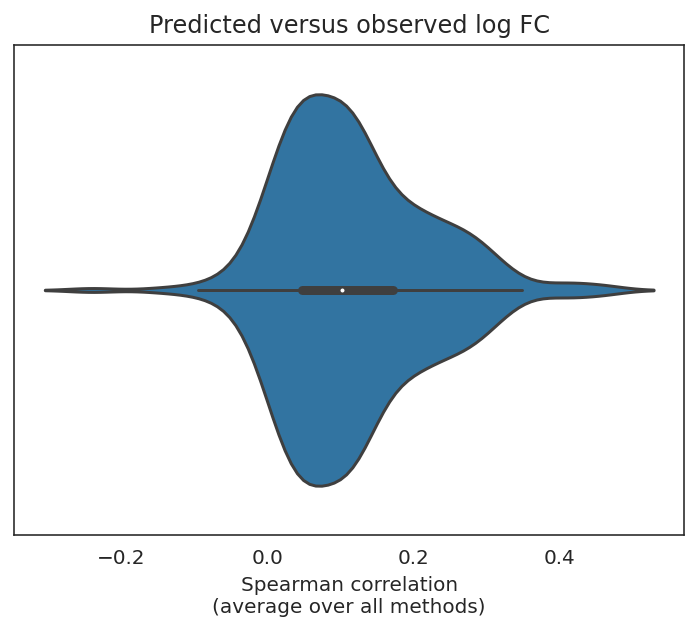

In [109]:
spearman_mean_across_methods = evaluationResults.groupby("perturbation")["spearman"].mean()
spearman_mean_across_methods = pd.DataFrame(spearman_mean_across_methods)
spearman_mean_across_methods.set_axis(['spearman_mean_across_methods'], axis=1, inplace=True)
evaluationResults = evaluationResults.merge(spearman_mean_across_methods, 
                                            how = "left", left_on="perturbation", right_index=True)
evaluationResults["spearman_improvement"] = evaluationResults["spearman"] - evaluationResults["spearman_mean_across_methods"]

# evaluationResults.index = evaluationResults.index.droplevel(0)
plotMeanSpearman = sns.violinplot( spearman_mean_across_methods.iloc[:,0])
plotMeanSpearman.set(title = "Predicted versus observed log FC", xlabel="Spearman correlation\n(average over all methods)")

In [110]:
noPredictionMade = evaluationResults.iloc[[x==0 for x in evaluationResults["spearman"]],:]['perturbation']
noPredictionMade = set(noPredictionMade)
noPredictionMade
evaluationResults["somePredictionRefused"] = evaluationResults["perturbation"].isin(noPredictionMade) 
evaluationResults.to_csv("../results/"+ VERSION +"/networksExperimentEvaluation.csv")
evaluationResults.head()

spearman     spearmanp perturbation  index network      p  \
0  0.000000  1.000000e+00      ANKRD22      0   dense  0.001   
1 -0.044359  2.576668e-01       ARID3A      0   dense  0.001   
2  0.104981  7.253813e-03        ARNT2      0   dense  0.001   
3  0.267149  3.917335e-12        ASCL1      0   dense  0.001   
4  0.089044  2.287158e-02        ASCL2      0   dense  0.001   

   threshold_number pruning  spearman_mean_across_methods  \
0              2000   harsh                      0.003575   
1              2000   harsh                     -0.044833   
2              2000   harsh                      0.085546   
3              2000   harsh                      0.212735   
4              2000   harsh                      0.078890   

   spearman_improvement  somePredictionRefused  
0             -0.003575                   True  
1              0.000474                  False  
2              0.019436                   True  
3              0.054413                   True  
4              0.010154                   True

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


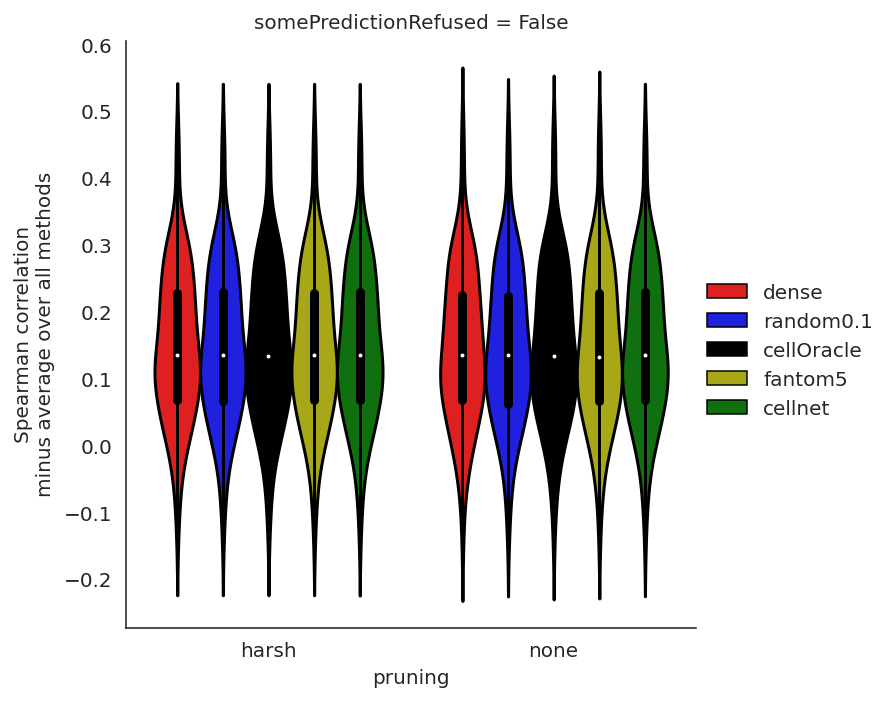

In [152]:
baseNetworkComparisonFigure = sns.FacetGrid(evaluationResults[~evaluationResults['somePredictionRefused']], 
                                            row ='somePredictionRefused', 
                                            sharey = False, 
                                            height=5, 
                                            aspect=1).set(title = "Performance")
baseNetworkComparisonFigure.map(sns.violinplot, "pruning", "spearman", "network", 
                                palette=["r", "b", "k", "y", "g"]
                               ).add_legend()
baseNetworkComparisonFigure.set(ylabel="Spearman correlation\nminus average over all methods")
plt.show()

In [148]:
summary = evaluationResults[~evaluationResults['somePredictionRefused']]
summary = summary.groupby(["pruning", "network"]).mean()
summary.to_csv("../results/" + VERSION + "/networksExperimentEvaluationSummary.csv")
print(summary)

                    spearman  spearmanp  index      p  threshold_number  \
pruning network                                                           
harsh   cellOracle  0.149212   0.098312    2.0  0.001            2000.0   
        cellnet     0.149383   0.098112    4.0  0.001            2000.0   
        dense       0.149218   0.098906    0.0  0.001            2000.0   
        fantom5     0.149293   0.098778    8.0  0.001            2000.0   
        random0.1   0.149394   0.098269    6.0  0.001            2000.0   
none    cellOracle  0.148198   0.099860    7.0  1.000       102313295.0   
        cellnet     0.149274   0.097901    9.0  1.000       102313295.0   
        dense       0.148022   0.102951    5.0  1.000       102313295.0   
        fantom5     0.148220   0.102161    3.0  1.000       102313295.0   
        random0.1   0.147746   0.100823    1.0  1.000       102313295.0   

                    spearman_mean_across_methods  spearman_improvement  \
pruning network          

<AxesSubplot:xlabel='spearman', ylabel='spearman_improvement'>

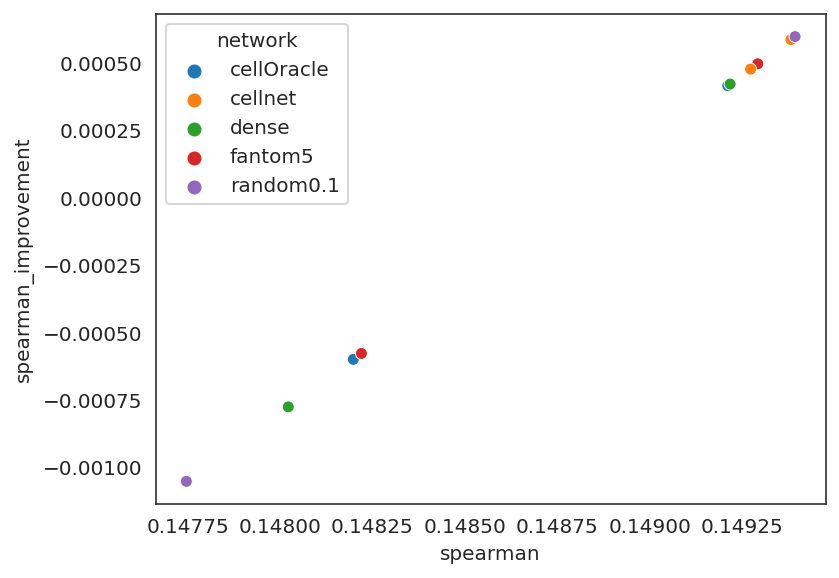

In [149]:
# Sanity check
sns.scatterplot(data = summary, x = "spearman", y = "spearman_improvement", hue = "network")